In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py

from matplotlib.gridspec import GridSpec

from numpy.polynomial.legendre import legval,legfit
import matplotlib as mpl
mpl.rcParams['font.size']=16
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"

import os
import glob

In [13]:
def get_relative_x2(d1,d2,e1,e2,
                    n1,n2,
                    leg_smooth=True,
                   cpsi=None,
                   max_deg=None, 
                    zero=False):
    if leg_smooth:
        d1 = filter_with_legPoly(cpsi,d1,max_deg) *n1/(n1+n2)

        d2 = filter_with_legPoly(cpsi,d2,max_deg) *n2/(n1+n2)
        
        e1 = filter_with_legPoly(cpsi,e1,max_deg)*n1/(n1+n2)
        e2 = filter_with_legPoly(cpsi,e2,max_deg)*n2/(n1+n2)
    print d1.shape
    if zero:
        d1-=d1.min(-1)[:,None]
        d2 -=d2.min(-1)[:,None]
    e=np.abs(d1-d2)/(np.sqrt((e1**2+e2**2)))
                     
    return e

def get_x2(d1,d2):
    e=np.abs(d1-d2)
    return e

def get_rmsd(d1,d2):
    return np.sqrt(((d1-d2)**2).mean(-1))

def get_relative_rmsd(d1,d2,smooth=False):
    if smooth:
        d1 = smooth_cors(d1)
        d2 = smooth_cors(d2)

    s = (d1+d2)*0.5
#     s-=s.min(-1)[:,None]
#     s=s.mean(-1)[:,None]
    s = (s.max(-1)-s.min(-1))[:,None]
    e = (d1-d2)/s
    return np.sqrt((e**2).mean(-1))

def filter_with_legPoly(cpsi,cor,max_deg):
    deg = range(0,max_deg,2)
    cor_legfit = np.zeros_like(cor)
    for ii in range(cor.shape[0]):
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        cor_legfit[ii] = legval(x,cc)
    return cor_legfit

def smooth(x, beta=10.0, window_size=11):
    """
    Apply a Kaiser window smoothing convolution.
    
    Parameters
    ----------
    x : ndarray, float
        The array to smooth.
        
    Optional Parameters
    -------------------
    beta : float
        Parameter controlling the strength of the smoothing -- bigger beta 
        results in a smoother function.
    window_size : int
        The size of the Kaiser window to apply, i.e. the number of neighboring
        points used in the smoothing.
        
    Returns
    -------
    smoothed : ndarray, float
        A smoothed version of `x`.
    """
    
    # make sure the window size is odd
    if window_size % 2 == 0:
        window_size += 1
    
    # apply the smoothing function
    s = np.r_[x[window_size-1:0:-1], x, x[-1:-window_size:-1]]
    w = np.kaiser(window_size, beta)
    y = np.convolve( w/w.sum(), s, mode='valid' )
    
    # remove the extra array length convolve adds
    b = (window_size-1) / 2
    smoothed = y[b:len(y)-b]
    
    return smoothed

def smooth_cors(d):
    smooth_d = np.zeros_like(d)
    for ii in range(d.shape[0]):
        smooth_d[ii] = smooth(d[ii])
    return smooth_d

In [14]:
cutoff = 0
cutoff2= 36
qvalues = np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_qvalue.npy')[cutoff:cutoff2]
cpsi = np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_cpsi.npy')[cutoff:cutoff2]

In [15]:
samples=['GDP_pro', 'GDP_buf','ALF_pro','ALF_buf']
cors1=[]
cors2 =[]
errs1=[]
errs2=[]
n_shots = []
phi_ofset=30
num_phi = 326
for ss in samples:
    
    f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/cali_gai_cor_results/%s_random_split.h5'%ss,'r')
    cors1.append(f['running_ave_cor'][0])
    cors2.append(f['running_ave_cor'][1])
    
    errs1.append(f['running_ave_err'][0])
    errs2.append(f['running_ave_err'][1])
    
    n_shots.append(f['running_num_shots'].value.mean(-1).sum()/2)

    
    f.close()

# phi_ofset=15
cors1 = np.array(cors1)
num_phi = cors1.shape[-1]
# cors1 = 0.5*(cors1[:,:,:num_phi/2]+cors1[:,:,num_phi/2:])
cors2 = np.array(cors2)
# cors2 = 0.5*(cors2[:,:,:num_phi/2]+cors2[:,:,num_phi/2:])

errs2=np.array(errs2)
errs1=np.array(errs1)
n_shots=np.array(n_shots)
print errs1.shape

all_cors = (cors1+cors2)/2
all_errs = np.sqrt((errs1**2+errs2**2)/2)

(4, 36, 326)


In [27]:
print np.array(n_shots)

[ 325431.5  125847.5  136033.   103157. ]


In [17]:
GDPdiff = 0.5*((cors1[0]+cors2[0])*n_shots[0]-(cors1[1]+cors2[1])*n_shots[1])/n_shots[:2].sum()
ALFdiff = 0.5*((cors1[2]+cors2[2])*n_shots[2]-(cors1[3]+cors2[3])*n_shots[3])/n_shots[2:].sum()
GDPdiff_err = np.sqrt((errs1[0]**2+errs2[0]**2)*n_shots[0]**2+(errs1[1]**2+errs2[1]**2)*n_shots[1]**2)/n_shots[:2].sum()
ALFdiff_err = np.sqrt((errs1[2]**2+errs2[2]**2)*n_shots[1]**2+(errs1[3]**2+errs2[3]**2)*n_shots[3]**2)/n_shots[2:].sum()

GDPdiff1 = cors1[0]-cors1[1]
GDPdiff2 = cors2[0]-cors2[1]

ALFdiff1 = cors1[2]-cors1[3]
ALFdiff2 = cors2[2]-cors2[3]

In [18]:
smooth_flag = True
max_deg=40
x2_GDPbuf = get_relative_x2(cors1[1, :,phi_ofset:num_phi/2-phi_ofset],
                            cors2[1, :,phi_ofset:num_phi/2-phi_ofset],
                            errs1[1,:,phi_ofset:num_phi/2-phi_ofset],
                            errs2[1,:, phi_ofset:num_phi/2-phi_ofset],
                            n_shots[1],n_shots[1],
                            leg_smooth=smooth_flag,cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)
x2_GDPpro = get_relative_x2(cors1[0, :,phi_ofset:num_phi/2-phi_ofset],
                            cors2[0, :,phi_ofset:num_phi/2-phi_ofset],
                            errs1[0,:,phi_ofset:num_phi/2-phi_ofset],
                            errs2[0,:, phi_ofset:num_phi/2-phi_ofset],
                            n_shots[0],n_shots[0],
                            leg_smooth=smooth_flag,cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)
x2_GDPpro_buf1 = get_relative_x2(all_cors[0, :,phi_ofset:num_phi/2-phi_ofset],
                            all_cors[1, :,phi_ofset:num_phi/2-phi_ofset],
                            all_errs[0,:,phi_ofset:num_phi/2-phi_ofset],
                            all_errs[1,:, phi_ofset:num_phi/2-phi_ofset],
                             n_shots[0],n_shots[1],
                            leg_smooth=smooth_flag,cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)

x2_ALFbuf = get_relative_x2(cors1[3, :,phi_ofset:num_phi/2-phi_ofset],
                            cors2[3, :,phi_ofset:num_phi/2-phi_ofset],
                            errs1[3,:,phi_ofset:num_phi/2-phi_ofset],
                            errs2[3,:, phi_ofset:num_phi/2-phi_ofset],
                            n_shots[3],n_shots[3],
                            leg_smooth=smooth_flag,cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)
x2_ALFpro = get_relative_x2(cors1[2, :,phi_ofset:num_phi/2-phi_ofset],
                            cors2[2, :,phi_ofset:num_phi/2-phi_ofset],
                            errs1[2,:,phi_ofset:num_phi/2-phi_ofset],
                            errs2[2,:, phi_ofset:num_phi/2-phi_ofset],
                            n_shots[2],n_shots[2],
                            leg_smooth=smooth_flag,cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)
x2_ALFpro_buf1 = get_relative_x2(all_cors[2, :,phi_ofset:num_phi/2-phi_ofset],
                            all_cors[3, :,phi_ofset:num_phi/2-phi_ofset],
                            all_errs[2,:,phi_ofset:num_phi/2-phi_ofset],
                            all_errs[3,:, phi_ofset:num_phi/2-phi_ofset],
                                 n_shots[2],n_shots[3],
                            leg_smooth=smooth_flag,cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)


(36, 103)
(36, 103)
(36, 103)
(36, 103)
(36, 103)
(36, 103)


In [19]:

x = cpsi[:,phi_ofset:num_phi/2-phi_ofset]
GDPpro_legfit1 =filter_with_legPoly(cpsi[:,phi_ofset:num_phi/2-phi_ofset],
                                cors1[0,:,phi_ofset:num_phi/2-phi_ofset],
                               max_deg)
GDPpro_legfit2 =filter_with_legPoly(cpsi[:,phi_ofset:num_phi/2-phi_ofset],
                                cors2[0,:,phi_ofset:num_phi/2-phi_ofset],
                               max_deg)
ALFpro_legfit1 =filter_with_legPoly(cpsi[:,phi_ofset:num_phi/2-phi_ofset],
                                   cors1[2,:,phi_ofset:num_phi/2-phi_ofset],
                               max_deg)
ALFpro_legfit2 =filter_with_legPoly(cpsi[:,phi_ofset:num_phi/2-phi_ofset],
                                   cors2[2,:,phi_ofset:num_phi/2-phi_ofset],
                               max_deg)

ALFbuf_legfit1 =filter_with_legPoly(cpsi[:,phi_ofset:num_phi/2-phi_ofset],
                                    cors1[1,:,phi_ofset:num_phi/2-phi_ofset],
                               max_deg)
ALFbuf_legfit2 =filter_with_legPoly(cpsi[:,phi_ofset:num_phi/2-phi_ofset],
                                    cors2[1,:,phi_ofset:num_phi/2-phi_ofset],
                               max_deg)
GDPbuf_legfit1 =filter_with_legPoly(cpsi[:,phi_ofset:num_phi/2-phi_ofset],
                                    cors1[3,:,phi_ofset:num_phi/2-phi_ofset],
                               max_deg)
GDPbuf_legfit2 =filter_with_legPoly(cpsi[:,phi_ofset:num_phi/2-phi_ofset],
                                    cors2[3,:,phi_ofset:num_phi/2-phi_ofset],
                               max_deg)

In [20]:


x2_GDP_ALF_legfit = get_relative_x2(GDPdiff[:,phi_ofset:num_phi/2-phi_ofset],
                                    ALFdiff[:,phi_ofset:num_phi/2-phi_ofset],
                                   GDPdiff_err[:,phi_ofset:num_phi/2-phi_ofset],
                                    ALFdiff_err[:,phi_ofset:num_phi/2-phi_ofset],
                                    n_shots[0],n_shots[2],
                                   leg_smooth=smooth_flag,
                                    cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)

x2_GDPbuf_ALFbuf= get_relative_x2(all_cors[1,:,phi_ofset:num_phi/2-phi_ofset],
                                    all_cors[3,:,phi_ofset:num_phi/2-phi_ofset],
                                   all_errs[1,:,phi_ofset:num_phi/2-phi_ofset],
                                    all_errs[3,:,phi_ofset:num_phi/2-phi_ofset],
                                  n_shots[1],n_shots[3], 
                                  leg_smooth=smooth_flag,
                                    cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)

x2_GDPpro_ALFpro= get_relative_x2(all_cors[0,:,phi_ofset:num_phi/2-phi_ofset],
                                    all_cors[2,:,phi_ofset:num_phi/2-phi_ofset],
                                   all_errs[0,:,phi_ofset:num_phi/2-phi_ofset],
                                    all_errs[2,:,phi_ofset:num_phi/2-phi_ofset],
                                  n_shots[0],n_shots[2],
                                   leg_smooth=smooth_flag,
                                    cpsi=cpsi[:, phi_ofset:num_phi/2-phi_ofset],
                           max_deg=max_deg)


(36, 103)
(36, 103)
(36, 103)


(-0.1, 1.1)

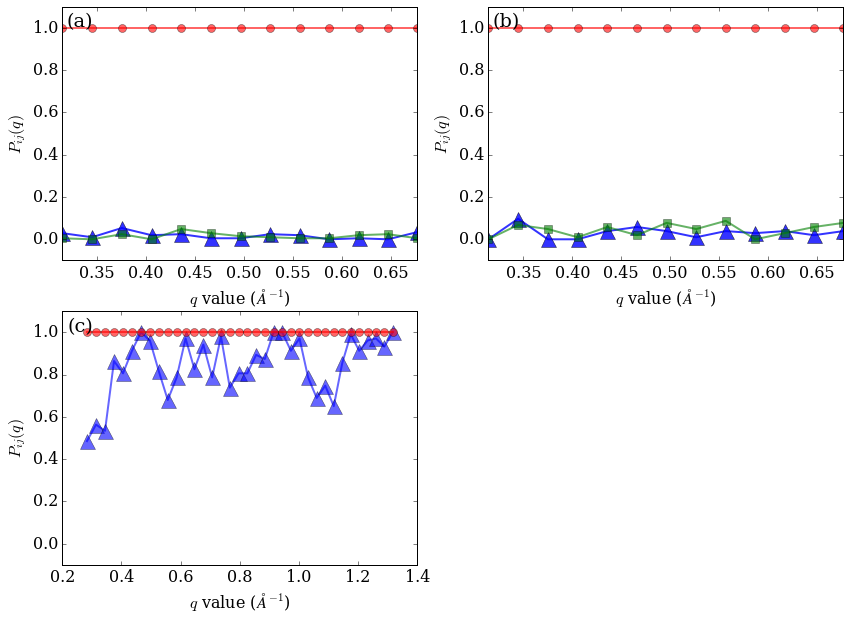

In [21]:
gs = GridSpec(2,2)
plt.figure(figsize=[14,10])
ax = plt.subplot(gs[0,0])
ax.set_title('(a)',x = 0.05,y=0.9)
plt.plot(qvalues,(x2_GDPbuf>1).sum(-1)/float(num_phi/2-phi_ofset*2)/2,
         '^-', linewidth=2, alpha = 0.8, markersize=15)
plt.plot(qvalues,(x2_GDPpro>1).sum(-1)/float(num_phi/2-phi_ofset*2)/2,
         's-', linewidth=2, alpha = 0.6,markersize=8)
plt.plot(qvalues,(x2_GDPpro_buf1>1).sum(-1)/float(num_phi/2-phi_ofset*2), 
         'o-',linewidth=2, alpha = 0.6, markersize=8)

plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$P_{ij}(q)$')
plt.ylim(-0.1,1.1)
plt.xlim(qvalues[11],qvalues[23])
plt.xlim(qvalues[1],qvalues[13])
#####ALF

ax = plt.subplot(gs[0,1])

ax.set_title('(b)',x = 0.05,y=0.9)
plt.plot(qvalues,(x2_ALFbuf>1).sum(-1)/float(num_phi/2-phi_ofset*2),
         '^-', linewidth=2, alpha = 0.8, markersize=15)
plt.plot(qvalues,(x2_ALFpro>1).sum(-1)/float(num_phi/2-phi_ofset*2),
         's-', linewidth=2, alpha = 0.6, markersize=8)
plt.plot(qvalues,(x2_ALFpro_buf1>1).sum(-1)/float(num_phi/2-phi_ofset*2), 
         'o-',linewidth=2, alpha = 0.6, markersize=8)

plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$P_{ij}(q)$')
plt.ylim(-0.1,1.1)
plt.xlim(qvalues[1],qvalues[13])
##########
ax=plt.subplot(gs[1,0])
ax.set_title('(c)',x = 0.05,y=0.9)
plt.plot(qvalues, (x2_GDPbuf_ALFbuf>1).sum(-1)/float(num_phi/2-phi_ofset*2),
         '^-', linewidth=2, alpha = 0.6, markersize=15)
plt.plot(qvalues, (x2_GDPpro_ALFpro>1).sum(-1)/float(num_phi/2-phi_ofset*2),
         'ro-', linewidth=2, alpha = 0.6, markersize=8)
# plt.plot(qvalues, (x2_GDP_ALF_legfit>1).sum(-1)/float(num_phi/2-phi_ofset*2),
#          'o-', linewidth=2, alpha = 0.6, markersize=8)

plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$P_{ij}(q)$')
plt.ylim(-0.1,1.1)
# plt.xlim(qvalues[1],qvalues[13])
# plt.savefig('validate_corr_signals.png',bbox_inches='tight')

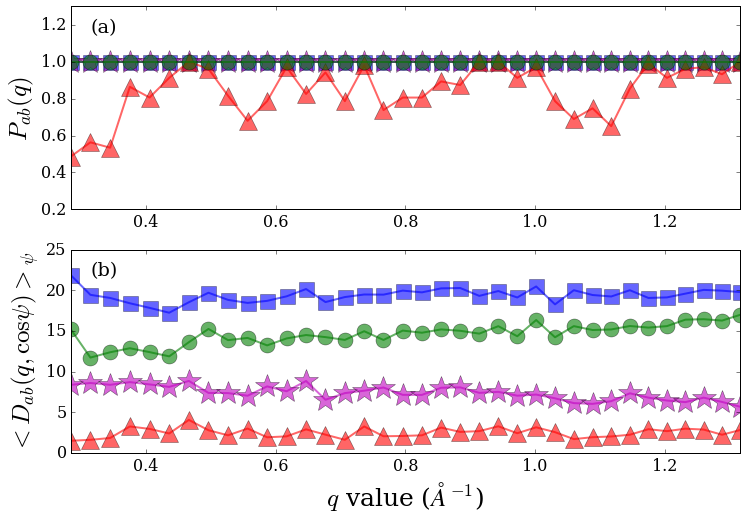

In [26]:
gs = GridSpec(2,1)
plt.figure(figsize=[12,8])
ax = plt.subplot(gs[0,0])
ax.set_title('(a)',x = 0.05,y=0.85)
###GDP
plt.plot(qvalues,(x2_GDPpro_buf1>1).sum(-1)/float(num_phi/2-phi_ofset*2), 
         'bs-',linewidth=2, alpha = 0.6, markersize=15)

#####ALF
plt.plot(qvalues,(x2_ALFpro_buf1>1).sum(-1)/float(num_phi/2-phi_ofset*2), 
         'm*-',linewidth=2, alpha = 0.6, markersize=25)

##########
plt.plot(qvalues, (x2_GDPbuf_ALFbuf>1).sum(-1)/float(num_phi/2-phi_ofset*2),
         'r^-', linewidth=2, alpha = 0.6, markersize=18)
plt.plot(qvalues, (x2_GDPpro_ALFpro>1).sum(-1)/float(num_phi/2-phi_ofset*2),
         'go-', linewidth=2, alpha = 0.6, markersize=15)

# plt.xlabel('$q$ value ($\AA^{-1}$)', fontsize = 25)
plt.ylabel('$P_{ab}(q)$', fontsize = 25)
plt.ylim(0.2,1.3)
# plt.ylim(-0.,1.1)
plt.xlim(qvalues[0],qvalues[-1])

ax = plt.subplot(gs[1,0])
ax.set_title('(b)',x = 0.05,y=0.85)
###GDP
plt.plot(qvalues,x2_GDPpro_buf1.mean(-1), 
         'bs-',linewidth=2, alpha = 0.6, markersize=15)

# #####ALF
plt.plot(qvalues,x2_ALFpro_buf1.mean(-1), 
         'm*-',linewidth=2, alpha = 0.6, markersize=25)

# ##########
plt.plot(qvalues, x2_GDPbuf_ALFbuf.mean(-1),
         'r^-', linewidth=2, alpha = 0.6, markersize=18)
plt.plot(qvalues, x2_GDPpro_ALFpro.mean(-1),
         'go-', linewidth=2, alpha = 0.6, markersize=15)

plt.xlabel('$q$ value ($\AA^{-1}$)', fontsize = 25)
plt.ylabel('$<D_{ab}(q, \cos \psi)>_{\psi}$', fontsize = 25)
# plt.ylim(-0.,1.1)
plt.xlim(qvalues[0],qvalues[-1])
# plt.xlim(qvalues[1],qvalues[13])
# plt.savefig('run16_gai_validate_corr_signals.png',bbox_inches='tight')

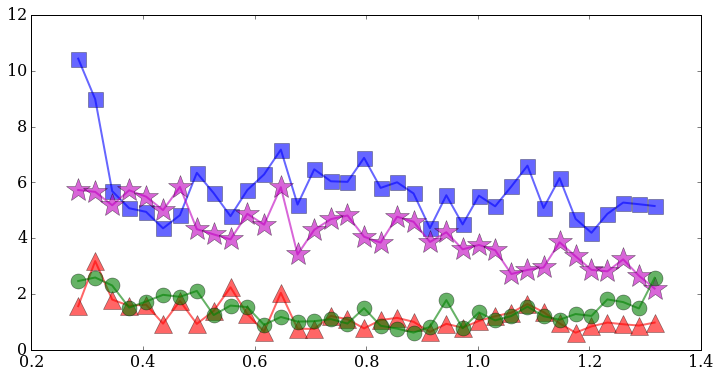

In [12]:
gs = GridSpec(1,1)
plt.figure(figsize=[12,6])
ax = plt.subplot(gs[0,0])
###GDP
plt.plot(qvalues,x2_GDPpro_buf1.mean(-1), 
         'bs-',linewidth=2, alpha = 0.6, markersize=15)

# #####ALF
plt.plot(qvalues,x2_ALFpro_buf1.mean(-1), 
         'm*-',linewidth=2, alpha = 0.6, markersize=25)

# ##########
plt.plot(qvalues, x2_GDPbuf_ALFbuf.mean(-1),
         'r^-', linewidth=2, alpha = 0.6, markersize=18)
plt.plot(qvalues, x2_GDPpro_ALFpro.mean(-1),
         'go-', linewidth=2, alpha = 0.6, markersize=15)

# plt.xlabel('$q$ value ($\AA^{-1}$)', fontsize = 25)
# plt.ylabel('$P_{ab}(q)$', fontsize = 25)
# plt.ylim(-0.,1.1)
# plt.xlim(qvalues[1],qvalues[13])
# # plt.savefig('validate_corr_signals2.png',bbox_inches='tight')

<Container object of 3 artists>

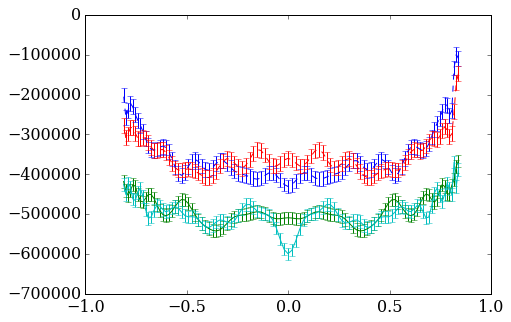

In [115]:
gs = GridSpec(1,2)
plt.figure(figsize=[16,5])
qidx = 20
plt.subplot(gs[0,0])
plt.errorbar(x[qidx],GDPbuf_legfit1[qidx]
             ,yerr=errs1[1,qidx,phi_ofset:num_phi/2-phi_ofset], linestyle='--')
# plt.errorbar(x[qidx],GDPbuf_legfit2[qidx]
#              ,yerr=errs1[1,qidx,phi_ofset:num_phi/2-phi_ofset])

plt.errorbar(x[qidx],GDPpro_legfit1[qidx]
             ,yerr=errs1[0,qidx,phi_ofset:num_phi/2-phi_ofset])
# plt.errorbar(x[qidx],GDPbuf_legfit2[qidx]
#              ,yerr=errs1[1,qidx,phi_ofset:num_phi/2-phi_ofset])
# plt.subplot(gs[0,1])
plt.errorbar(x[qidx],ALFbuf_legfit1[qidx]
             ,yerr=errs1[1,qidx,phi_ofset:num_phi/2-phi_ofset], linestyle='--')
# plt.errorbar(x[qidx],ALFbuf_legfit2[qidx]
#              ,yerr=errs1[1,qidx,phi_ofset:num_phi/2-phi_ofset])

plt.errorbar(x[qidx],ALFpro_legfit1[qidx]
             ,yerr=errs1[0,qidx,phi_ofset:num_phi/2-phi_ofset])
# plt.errorbar(x[qidx],ALFbuf_legfit2[qidx]
#              ,yerr=errs1[1,qidx,phi_ofset:num_phi/2-phi_ofset])

# plt.errorbar(x[qidx],ALFdiff[qidx,phi_ofset:num_phi/2-phi_ofset]
#              ,yerr=ALFdiff_err[qidx,phi_ofset:num_phi/2-phi_ofset])

In [ ]:
smooth_flag = True
rmx2_GDPbuf = get_relative_rmsd(cors1[1],cors2[1],smooth=smooth_flag)
rmx2_GDPpro = get_relative_rmsd(cors1[0],cors2[0],smooth=smooth_flag)
rmx2_GDPpro_buf1 = get_relative_rmsd(cors1[0],cors1[1],smooth=smooth_flag)
rmx2_GDPpro_buf2 = get_relative_rmsd((cors2[0]+cors1[0])/2.,(cors2[1]+cors1[1])/2.,
                                    smooth=smooth_flag)

rmx2_ALFbuf = get_relative_rmsd(cors1[3],cors2[3],smooth=smooth_flag)
rmx2_ALFpro = get_relative_rmsd(cors1[2],cors2[2],smooth=smooth_flag)
rmx2_ALFpro_buf1 = get_relative_rmsd(cors1[2],cors1[3],smooth=smooth_flag)
rmx2_ALFpro_buf2 = get_relative_rmsd(cors2[2],cors2[3],smooth=smooth_flag)


In [ ]:
plt.figure(figsize=[16,10])
gs = GridSpec(2,2)
plt.subplot(gs[0,0])
plt.plot(qvalues,rmx2_GDPbuf, 'o-',linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_GDPpro, 'o-',linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_GDPpro_buf2, 'o-',linewidth=3, alpha = 0.6)
plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$\sqrt{<\chi^2>(q)}$')

plt.subplot(gs[0,1])
plt.plot(qvalues,rmx2_ALFbuf,'o-', linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_ALFpro, 'o-',linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_ALFpro_buf1, 'o-',linewidth=3, alpha = 0.6)

plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$\sqrt{<\chi^2>(q)}$')
###### log scale
plt.subplot(gs[1,0])
plt.semilogy(qvalues,rmx2_GDPbuf,'o-', linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_GDPpro,'o-', linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_GDPpro_buf2, 'o-',
         linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_GDPpro_buf1, 'o-',
         linewidth=3, alpha = 0.6)
plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$\sqrt{<\chi^2>(q)}$')

plt.subplot(gs[1,1])
plt.semilogy(qvalues,rmx2_ALFbuf,'o-', linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_ALFpro,'o-', linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_ALFpro_buf1, 'o-',linewidth=3, alpha = 0.6)

plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$\sqrt{<\chi^2>(q)}$')

In [ ]:
plt.figure(figsize=[16,5])
gs = GridSpec(1,2)

###### log scale
ax=plt.subplot(gs[0,0])
ax.set_title('(a)',x = 0.05,y=0.9)
plt.semilogy(qvalues,rmx2_GDPbuf,'o-', linewidth=3, alpha = 0.6)

plt.plot(qvalues,rmx2_GDPpro,'o-', linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_GDPpro_buf2, 'o-',
         linewidth=3, alpha = 0.6)
plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$\sqrt{<\chi^2>(q)}$')

ax=plt.subplot(gs[0,1])
ax.set_title('(a)',x = 0.05,y=0.9)
plt.semilogy(qvalues,rmx2_ALFbuf,'o-', linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_ALFpro,'o-', linewidth=3, alpha = 0.6)
plt.plot(qvalues,rmx2_ALFpro_buf1, 'o-',linewidth=3, alpha = 0.6)

plt.xlabel('$q$ value ($\AA^{-1}$)')
plt.ylabel('$\sqrt{<\chi^2>(q)}$')

# plt.savefig('x2_protein_buffer.png',bbox_in_inches='tight')

In [ ]:

rmx2_GDPdiff = get_relative_rmsd(GDPdiff1,GDPdiff2,smooth=smooth_flag)
rmx2_ALFdiff = get_relative_rmsd(ALFdiff1,ALFdiff2,smooth=smooth_flag)
rmx2_GDP_ALF = get_relative_rmsd(GDPdiff,ALFdiff,smooth=smooth_flag)



In [ ]:
ALFdiff.shape
f_out = h5py.File('/reg/d/psdm/cxi/cxilp6715/results/validation/pca_remove_cors.h5','w')
f_out.create_dataset('ALFdiff',data=ALFdiff)
f_out.create_dataset('ALFdiff_err',data=ALFdiff_err)
f_out.create_dataset('GDPdiff',data=GDPdiff)
f_out.create_dataset('GDPdiff_err',data=GDPdiff_err)
f_out.close()

# plt.plot( (x2_GDP_ALF_legfit>1).sum(-1)/117.)


In [ ]:
plt.figure(figsize=[6,12])
qinds=[0,1,2,3]
gs = GridSpec(4,1)
for ii,qidx in enumerate(qinds):
    plt.subplot(gs[ii,0])
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],GDPdiff[qidx,phi_ofset:num_phi/2-phi_ofset],'b-')
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],GDP_legfit[qidx])
    # plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],GDP_legfit1[qidx])
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],ALFdiff[qidx,phi_ofset:num_phi/2-phi_ofset],'m-')
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],ALF_legfit[qidx])

In [ ]:
plt.figure(figsize=[16,12])
qinds=[0,1,6,15]
gs = GridSpec(4,2)
for ii,qidx in enumerate(qinds):
    plt.subplot(gs[ii,0])
    y = cors1[0,qidx,phi_ofset:num_phi/2-phi_ofset].copy()
#     y-=y.min(-1)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],y,'b.', alpha=0.5)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],smooth(y),'b-', 
             linewidth = 3, alpha=0.6)

    y = cors2[0,qidx,phi_ofset:num_phi/2-phi_ofset].copy()
#     y-=y.min(-1)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],y,'y.', alpha=0.5)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],smooth(y),'y-', 
             linewidth = 3, alpha=0.6)
    ######
    y = cors1[1,qidx,phi_ofset:num_phi/2-phi_ofset].copy()
#     y-=y.min()
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],y,'g^', alpha=0.5)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],smooth(y),'g-', 
             linewidth = 3, alpha=0.6)

# qinds=[0,1,2,3]
# gs = GridSpec(4,1)
for ii,qidx in enumerate(qinds):
    plt.subplot(gs[ii,1])
    y = cors1[2,qidx,phi_ofset:num_phi/2-phi_ofset].copy()
#     y-=y.min(-1)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],y,'b.', alpha=0.5)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],smooth(y),'b-', 
             linewidth = 3, alpha=0.6)

    y = cors2[2,qidx,phi_ofset:num_phi/2-phi_ofset].copy()
#     y-=y.min(-1)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],y,'y.', alpha=0.5)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],smooth(y),'y-', 
             linewidth = 3, alpha=0.6)
    ######
    y = cors1[3,qidx,phi_ofset:num_phi/2-phi_ofset].copy()
#     y-=y.min()
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],y,'g^', alpha=0.5)
    plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],smooth(y),'g-', 
             linewidth = 3, alpha=0.6)

In [ ]:
rmx2_GDPbuf_ALFbuf = get_relative_rmsd(cors1[1],cors2[3],smooth=smooth_flag)
rmx2_GDPpro_ALFpro = get_relative_rmsd(cors1[0],cors2[2],smooth=smooth_flag)

plt.semilogy(rmx2_GDPbuf_ALFbuf)
plt.plot(rmx2_GDPpro_ALFpro)
plt.plot(rmx2_GDP_ALF)

In [ ]:
qidx = 5
plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],GDPdiff[qidx,phi_ofset:num_phi/2-phi_ofset])
plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],GDP_legfit[qidx])
# plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],GDP_legfit1[qidx])
plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],ALFdiff[qidx,phi_ofset:num_phi/2-phi_ofset])
plt.plot(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],ALF_legfit[qidx])

In [ ]:
rmx2_GDPbuf = get_rmsd(cors1[1],cors2[1])
rmx2_GDPpro = get_rmsd(cors1[0],cors2[0])
rmx2_GDPpro_buf1 = get_rmsd(cors1[0],cors1[1])
rmx2_GDPpro_buf2 = get_rmsd(cors2[0],cors2[1])

plt.semilogy(rmx2_GDPbuf)
plt.plot(rmx2_GDPpro)
# plt.plot(rmx2_GDPpro_buf1)

plt.plot(rmx2_GDPpro_buf2)

In [ ]:
rmx2_ALFbuf = get_rmsd(cors1[3],cors2[3])
rmx2_ALFpro = get_rmsd(cors1[2],cors2[2])
rmx2_ALFpro_buf1 = get_rmsd(cors1[2],cors1[3])
rmx2_ALFpro_buf2 = get_rmsd(cors2[2],cors2[3])

plt.semilogy(rmx2_ALFbuf)
plt.plot(rmx2_ALFpro)
# plt.plot(rmx2_ALFpro_buf1)

plt.plot(rmx2_ALFpro_buf2)

In [ ]:
G

In [ ]:
rmx2_GDPpro_buf1==rmx2_GDPpro_buf2

In [ ]:
d_GDPpro = get_relative_x2(cors1[0],cors2[0],errs1[0],errs2[0])
d_GDPpro_buf = get_relative_x2(cors1[0],cors1[1],errs1[0],errs1[1])

x2_GDPpro = get_x2(cors1[0],cors2[0])
x2_GDPpro_buf = get_x2(cors1[0],cors1[1])

In [ ]:
qidx = 23
phi_ofset = 10
num_phi = 354
plt.plot(d_GDPpro[qidx, phi_ofset:num_phi/2-phi_ofset])
plt.plot(d_GDPpro_buf[qidx, phi_ofset:num_phi/2-phi_ofset])

In [ ]:
qidx = 28
phi_ofset = 30
num_phi = 354
plt.plot(x2_GDPpro[qidx, phi_ofset:num_phi/2-phi_ofset])
plt.plot(x2_GDPpro_buf[qidx, phi_ofset:num_phi/2-phi_ofset])

In [ ]:
plt.plot((d_GDPpro>1).sum(-1)/float(d_GDPpro.shape[-1]) )
plt.plot((d_GDPpro_buf>1).sum(-1)/float(d_GDPpro.shape[-1]))

In [ ]:
qidx = 10
plt.errorbar(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],cors1[0,qidx,phi_ofset:num_phi/2-phi_ofset]
             ,yerr = errs1[0,qidx,phi_ofset:num_phi/2-phi_ofset])
plt.errorbar(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],cors2[0,qidx,phi_ofset:num_phi/2-phi_ofset]
        ,yerr = errs2[0,qidx,phi_ofset:num_phi/2-phi_ofset])

plt.errorbar(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],cors2[1,qidx,phi_ofset:num_phi/2-phi_ofset]
        ,yerr = errs2[1,qidx,phi_ofset:num_phi/2-phi_ofset])

# plt.errorbar(range(354/2-30),cors2[2,qidx,15:354/2-15]
#         ,yerr = errs2[1,qidx,15:354/2-15])
# plt.errorbar(range(354/2-30),cors2[3,qidx,15:354/2-15]
#         ,yerr = errs2[1,qidx,15:354/2-15])

In [ ]:
qidx = 12
plt.errorbar(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],cors1[2,qidx,phi_ofset:num_phi/2-phi_ofset]
             ,yerr = errs1[2,qidx,phi_ofset:num_phi/2-phi_ofset])
plt.errorbar(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],cors2[2,qidx,phi_ofset:num_phi/2-phi_ofset]
        ,yerr = errs2[2,qidx,phi_ofset:num_phi/2-phi_ofset])

plt.errorbar(cpsi[qidx,phi_ofset:num_phi/2-phi_ofset],cors2[3,qidx,phi_ofset:num_phi/2-phi_ofset]
        ,yerr = errs2[3,qidx,phi_ofset:num_phi/2-phi_ofset])

In [ ]:
f_out = h5py.File('/reg/d/psdm/cxi/cxilp6715/results/validation/GDP_pro_random_split_maskDivide.h5','r')

In [ ]:
f_out.keys()
keys =[kk for kk in f_out.keys() if not kk.startswith('run')]
print keys
# for kk in keys:
#     f_out.__delitem__(kk)
print f_out.keys()

In [ ]:
print('aggregating results')
ave_cor1 =[]
ave_cor2=[]
total_shots1=[]
total_shots2 = []
err1 = []
err2 = []

keys=[kk for kk in f_out.keys() if kk.startswith('run')]

for kk in keys:
    ave_cor1.append(f_out[kk]['ave_cor1'].value)
    ave_cor2.append(f_out[kk]['ave_cor2'].value)

    total_shots1.append(f_out[kk]['num_shots1'].value)
    total_shots2.append(f_out[kk]['num_shots2'].value)

    err1.append(f_out[kk]['err1'].value)
    err2.append(f_out[kk]['err2'].value)
ave_cor1=np.array(ave_cor1)
ave_cor2=np.array(ave_cor2)

err1 = np.array(err1)
err2 = np.array(err2)

total_shots1=np.array(total_shots1)
total_shots2=np.array(total_shots2)

cor1 = (ave_cor1 *(total_shots1.astype(float)/total_shots1.sum(0)[None,:])[:,:,None]).sum(0)
cor2 = (ave_cor2 *(total_shots2.astype(float)/total_shots2.sum(0)[None,:])[:,:,None]).sum(0)

total_err1 = np.sqrt((err1**2 *total_shots1[:,:,None]**2).sum(0))/total_shots1.sum(0)[:,None]
total_err2 = np.sqrt((err2**2 *total_shots2[:,:,None]**2).sum(0))/total_shots2.sum(0)[:,None]

f_out.create_dataset('ave_cor1',data=cor1)
f_out.create_dataset('ave_cor2',data=cor2)
f_out.create_dataset('err1',data=total_err1)
f_out.create_dataset('err2',data=total_err2)

f_out.create_dataset('num_shots1',data=total_shots1)
f_out.create_dataset('num_shots2',data=total_shots2)

print('Done!')
f_out.close()

In [6]:
a =int(1)**2.
a/2

0.5

In [ ]:
total_shots1.sum(0)
f_out.close()

In [ ]:
keys =[kk for kk in f_out.keys() if not kk.startswith('run')]
f_out.create_dataset('ave_cor1',data=cor1)
f_out.create_dataset('ave_cor2',data=cor2)
f_out.create_dataset('err1',data=total_err1)
f_out.create_dataset('err2',data=total_err2)

f_out.create_dataset('num_shots1',data=total_shots1)
f_out.create_dataset('num_shots2',data=total_shots2)

print('Done!')